# AwkwardNN Under the Hood

- Here, I explain how AwkwardNN processes the fields
from a given root file and yaml file. I don't show much
python code here, that can be seen in the python files.

- I will look specifically at training fields in the file
`test_ttbar_1000.root`

## Overview of AwkwardNN Structure

- An _AwkwardNN block_ is a network block with four different
types of subnetworks (each corresponding to a different data
interpretation from `uproot`):
    - a fixed network
    - a jagged network
    - an object network
    - a nested network

- There is final network on top of these four subnetworks that
takes in the concatenated outputs from the subnetworks.

The yaml file is essentially one big AwkwardNN block.

Furthermore, nested blocks are composed of AwkwardNN blocks
because nested fields have a tree structure.


In [1]:
import uproot
from awkwardNN.utils.dataset_utils_uproot import get_events_from_tree

tree = uproot.open("../data/test_ttbar_1000.root")['Delphes']

## Fixed Network Block

- Possible modes:
    - `mlp`
    - `deepset`

- Input: fixed interpreted arrays

- Feeds forward like a normal neural network or deepset model

- This deepset model consists of 2 networks:
    - the first network takes each individual element of an array
    as its input,
    - the second network takes the element-wise sum of the
    outputs from the first network as its input.

- Output: latent array whose length with length `embed_dim` from
yaml file

In [2]:
# Example of fixed data

fixed_fields = ['Jet_size', 'Particle_size', 'Muon_size', 'Event_size']
fixed_data = get_events_from_tree(tree, fixed_fields)

for i in range(5):
    print("Event {}: {}".format(i+1, fixed_data[i]))


Event 1: tensor([[  4., 737.,   0.,   1.]])
Event 2: tensor([[  2., 682.,   0.,   1.]])
Event 3: tensor([[4.0000e+00, 1.2670e+03, 0.0000e+00, 1.0000e+00]])
Event 4: tensor([[4.0000e+00, 1.3900e+03, 0.0000e+00, 1.0000e+00]])
Event 5: tensor([[  3., 792.,   0.,   1.]])


## Jagged Network Block

- Possible modes:
    - `lstm`
    - `gru`
    - `vanilla_rnn`
    - `deepset`

- Input: jagged interpreted arrays

- Feeds forward like a recurrent neural network or deepset model.

- This deepset model consists of 2 networks:
    - the first network takes arrays of fixed length as its input,
    - the second network takes the element-wise sum of all the
    outputs from the first network as its input.

- Output: latent array whose length with length `embed_dim` from
yaml file


In [3]:
# Example of jagged data

jagged_fields = ['Jet.Mass', 'Jet.Eta', 'Jet.Phi']
jagged_data = get_events_from_tree(tree, jagged_fields)

for i in range(5):
    print("Event {}: {}\n".format(i+1, jagged_data[i]))

Event 1: tensor([[[206.9777,   0.2733,   0.8877]],

        [[179.3755,  -0.3325,  -2.4103]],

        [[ 10.8406,   0.4900,  -0.2258]],

        [[ 14.2367,   3.0309,  -1.9108]]])

Event 2: tensor([[[ 1.8060e+02, -1.5794e-01,  1.7673e+00]],

        [[ 1.3347e+02,  4.8330e-01, -1.3502e+00]]])

Event 3: tensor([[[ 2.1602e+02,  7.0078e-01,  3.0060e+00]],

        [[ 1.6781e+02,  3.7453e-01, -1.4007e-01]],

        [[ 8.5620e+00,  3.4655e+00, -2.3441e+00]],

        [[ 7.6187e+00,  1.8378e-01, -1.2875e+00]]])

Event 4: tensor([[[ 1.9608e+02,  2.4928e-01,  2.6330e+00]],

        [[ 1.6945e+02, -4.2195e-01, -2.9568e-01]],

        [[ 6.0668e+01, -1.1219e-01, -2.1356e+00]],

        [[ 1.4514e+01,  2.9883e+00, -9.5512e-01]]])

Event 5: tensor([[[185.3319,  -0.9399,   1.6659]],

        [[215.2863,  -0.8183,  -1.5329]],

        [[ 13.3948,   2.9999,   0.3681]]])



## Object Network Block

- Possible modes:
    - `lstm`
    - `gru`
    - `vanilla_rnn`
    - `deepset`

- Input: object interpreted arrays

- Difference from jagged arrays:
    - Each event has a varying number of subobjects, e.g. jets,
    but each subobject also has a varying number of elements too.

    - Therefore, can't just use a normal RNN that sequentially
    processes an event one jet at a time.

- (Ad Hoc) Feeds forward like a modified recurrent neural network
or deepset model.

- Modified RNN consists of 2 RNNs stacked on top of each other:
    - the first RNN:
        - takes as input each subevent (e.g. jet in an event)
        - sequentially processes it one element at a time,
        - returns a hidden state for each subevent.
    - the second RNN:
        - takes as input all the hidden states from the first RNN,
        - processes them sequentially one at a time,
        - returns latent array.

- this modified deepset model is composed of 2 standard deepset
models stacked on top of each other:
    - the first deepset model:
        - takes each subevent,
        - feeds forward through its phi network one element at time,
        - element-wise sums the outputs from the phi network,
        - feeds forward through its rho network, and
        - returns a hidden state for each subevent.
    - the second deepset model:
        - takes the outputs from the first deepset model,
        - passes each one through its phi network,
        - sums the latent state for each subevent,
        - feeds forward through its rho network,
        - returns latent array.

Is this how it should feed forward? I'm not sure. I don't think
I've ever seen this type of data format used in this context
before.

In [4]:
# Example of object data

object_fields = ['Jet.Constituents', 'Jet.Particles']
object_data = get_events_from_tree(tree, object_fields)

for i in range(5):
    print("Event {}: number of jets {}".format(i+1, len(object_data[i])))
    for j, obj_array in enumerate(object_data[i]):
        print("  jet {} has length {}".format(j+1, len(obj_array)))
    print()


/Users/edisonweik/.pyenv/versions/3.6.11/lib/python3.6/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return cls.numpy.array(value, copy=False)


Event 1: number of jets 4
  jet 1 has length 107
  jet 2 has length 140
  jet 3 has length 20
  jet 4 has length 25

Event 2: number of jets 2
  jet 1 has length 126
  jet 2 has length 132

Event 3: number of jets 4
  jet 1 has length 148
  jet 2 has length 174
  jet 3 has length 19
  jet 4 has length 18

Event 4: number of jets 4
  jet 1 has length 131
  jet 2 has length 128
  jet 3 has length 84
  jet 4 has length 29

Event 5: number of jets 3
  jet 1 has length 81
  jet 2 has length 134
  jet 3 has length 32



## Nested Network Block

- Possible modes:
    - `lstm`
    - `gru`
    - `vanilla_rnn`
    - `mlp`
    - `deepset`
        - Note: same `deepset` model here as the one in jagged block

- Input: latent arrays from AwkwardNN subblocks
    - Recall: a nested field from a rootfile has its own tree structure

- How it feeds forward depends on the mode.

- If the mode is `lstm`, `gru`, `vanilla_rnn`, or `deepset`:
    - The network sequentially processing the AwkwardNN subblocks one at a time.
    - Then returns the latent array.

    - Note: sometimes subevents are null within an event.
        - E.g. an event may have 5 jets but 0 muons.
        - In this case, the `Muon` block would be skipped over by the network
        (as opposed to being zero padded).

- If the mode is `mlp`:
    - The network concatenates the outputs from all of the its AwkwardNN
    subblocks,
    - The feeds forward like a conventional MLP.

    - Note: If a subevent is null, then the input would have to be zero
    padded because an MLP cannot accomodate a variable input lengths.d


## AwkwardNN Block

- Possible modes:
    - `mlp`
    - `deepset`
        - Note: same `deepset` model here as the one in fixed block

- Input:  the concatenation of the latent array outputs from
 of all of its subblocks.

    - Note: not every type of subblock may be present.

    - If the list of fields doesn't have a type of data interpretation
    present, then there will be no associated subblock.


## Visualize Awkward NN

- Can visualize the higher level structure of AwkwardNN and how
its component blocks are organized



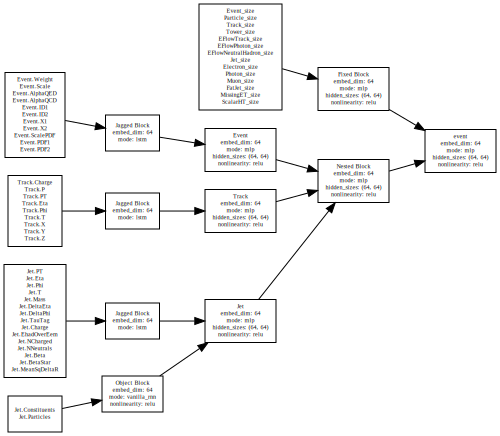

In [5]:
from awkwardNN.visualize_network import visualize_network
import awkwardNN.utils.yaml_utils as yaml_utils
yaml_filename = '../test_qcd_1000_demo.yaml'
yaml_dict = yaml_utils.get_yaml_dict_list(yaml_filename)
graph = visualize_network(yaml_dict, fontsize=6)
graph



